# Supervised learning for object classification with neural networks, support vector machine and random forest classifiers

## Authors: 
Djordje Savic (Postdoc)  
Isidora Jankov (PhD student)  

## Assistant:  
Iva Čvorović-Hajdinjak (PhD student)

## Code specification

**Reproducibility:**  
This is an end-to-end example reproducible in the SciServer Essentials 2.0 with the preinstalled Python environment "py38" with tensorflow installed. The user should navigate to Stripe82 Object Table 's82ObjectTable.parquet'.  

**Should the notebook be run on the blinded dataset?**  
We would like to have models evaluated on the blinded dataset.

**Working with already trained models**  
There are no saved models in this example due to the fast training on SciServer. This notebook has been run on a server with 80 cores and 512 GB RAM memory with no additional packages installed.

**Code version:** in development phase

**Sample:** Tests performed on a subsample with size of ~64,000 objects (50% of the AGN DC Stripe82 Object Table when NaN values are excluded).


## Contents:

1. Introduction and motivation
2. Data reading and pre-processing
3. Neural network classifier
4. Support vector machine classifier
5. Random forest classifier
6. Conclusion

## 1. Introduction and motivation
The main goal of this work is to investigate how different machine learning algorithms perform on tabular data loaded from Stripe82 Object Table. We used a simple neural network (NN), support vector machine (SVM) and random forest (RF). The comparison of performance of each method is a good starting point towards building more advanced models. The overall performance is summarized in the conclusion and possible improvements have been applied in two additional notebooks.

## 2. Data reading, selection and pre-processing


In [2]:
## commonly used modules
import pandas as pd
import numpy as np
import tensorflow as tf
#import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import matplotlib as mpl
import os, sys
import yaml
import seaborn as sns
import importlib

from sklearn import linear_model
from sklearn import model_selection
from sklearn import metrics
from sklearn import datasets 
from sklearn import preprocessing
from sklearn import svm, datasets
from sklearn.ensemble import RandomForestClassifier
import sklearn.model_selection as model_selection
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from scipy.stats import spearmanr
# import MLdefs

pd.set_option('display.max_columns', 1000)

In [3]:
#"/home/idies/workspace/Storage/djsavic/persistent/LSST_training/Script_NBs/Kodovi" # scripts are located in this directory

## Data challenge root data dir
data_dir = 'Datasets/s82ObjectTable.parquet'
#data_dir = "./Datasets/"

# Examine the data directory
display(data_dir)
#!ls "/home/idies/workspace/Temporary/ywx649999311/LSST_AGN/Class_Training/DC/"

'Datasets/s82ObjectTable.parquet'

### Data selection
The object table follows the current version of the LSST Data Products document (LSE-163) as much as possible with measurements of included objects in the following main catalogries:
- __Astromety__ -> ra, dec, proper motion and parallax
- __Photometry__ -> point and extended source photometry, in both AB magnitdues and fluxes (nJy)
- __Color__ -> Computed using the fluxes
- __Morphology__ -> 1 for extended and 0 for point-like
- __Light Curve Features__ -> Extrated on the SDSS light curves if matched
- __Redshift__ -> Both spectroscopic and photometric, wherever available

In [4]:
# reading S82 object table
object_df = pd.read_parquet(os.path.join(data_dir))
#object_df = pd.read_csv(os.path.join(data_dir, 's82ObjectTableDF.csv')) #
display(object_df.describe())
display(object_df.shape)
# Number of objects in each class + unlabeled
display(object_df['class'].value_counts())
display("Number of unlabeled objects: {}".format(object_df['class'].isna().sum()))

/home/yan/PythonWorkdir/MASS_SummerSchool/.ai_env/lib/python3.12/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: overflow encountered in square
  sqr = _ensure_numeric((avg - values) ** 2)


,ra,dec,psPm_ra,psPm_dec,psParallax,psFlux_u,psFlux_g,psFlux_r,psFlux_i,psFlux_z,psFlux_y,psFluxErr_u,psFluxErr_g,psFluxErr_r,psFluxErr_i,psFluxErr_z,psFluxErr_y,bdFlux_u,bdFlux_g,bdFlux_r,bdFlux_i,bdFlux_z,bdFlux_y,bdFluxErr_u,bdFluxErr_g,bdFluxErr_r,bdFluxErr_i,bdFluxErr_z,bdFluxErr_y,psMag_u,psMag_g,psMag_r,psMag_i,psMag_z,psMag_y,psMagErr_u,psMagErr_g,psMagErr_r,psMagErr_i,psMagErr_z,psMagErr_y,bdMag_u,bdMag_g,bdMag_r,bdMag_i,bdMag_z,bdMag_y,bdMagErr_u,bdMagErr_g,bdMagErr_r,bdMagErr_i,bdMagErr_z,bdMagErr_y,extendedness_u,extendedness_g,extendedness_r,extendedness_i,extendedness_z,extendedness_y,stdColor_0,stdColor_1,stdColor_2,stdColor_3,stdColor_4,stdColorErr_0,stdColorErr_1,stdColorErr_2,stdColorErr_3,stdColorErr_4,photoZ_pest,z,flags_u,flags_g,flags_r,flags_i,flags_z,flags_y,lcPeriodic[0]_g,lcPeriodic[0]_r,lcPeriodic[0]_i,lcPeriodic[1]_g,lcPeriodic[1]_r,lcPeriodic[1]_i,lcPeriodic[2]_g,lcPeriodic[2]_r,lcPeriodic[2]_i,lcPeriodic[3]_g,lcPeriodic[3]_r,lcPeriodic[3]_i,lcPeriodic[4]_u,lcPeriodic[4]_g,lcPeriodic[4]_r,lcPeriodic[4]_i,lcPeriodic[4]_z,lcPeriodic[5]_u,lcPeriodic[5]_g,lcPeriodic[5]_r,lcPeriodic[5]_i,lcPeriodic[5]_z,lcPeriodic[6]_u,lcPeriodic[6]_g,lcPeriodic[6]_r,lcPeriodic[6]_i,lcPeriodic[6]_z,lcPeriodic[7]_u,lcPeriodic[7]_g,lcPeriodic[7]_r,lcPeriodic[7]_i,lcPeriodic[7]_z,lcPeriodic[8]_u,lcPeriodic[8]_g,lcPeriodic[8]_r,lcPeriodic[8]_i,lcPeriodic[8]_z,lcPeriodic[9]_u,lcPeriodic[9]_g,lcPeriodic[9]_r,lcPeriodic[9]_i,lcPeriodic[9]_z,lcPeriodic[10]_u,lcPeriodic[10]_g,lcPeriodic[10]_r,lcPeriodic[10]_i,lcPeriodic[10]_z,lcPeriodic[11]_u,lcPeriodic[11]_g,lcPeriodic[11]_r,lcPeriodic[11]_i,lcPeriodic[11]_z,lcPeriodic[12]_u,lcPeriodic[12]_g,lcPeriodic[12]_r,lcPeriodic[12]_i,lcPeriodic[12]_z,lcPeriodic[13]_u,lcPeriodic[13]_g,lcPeriodic[13]_r,lcPeriodic[13]_i,lcPeriodic[13]_z,lcPeriodic[14]_u,lcPeriodic[14]_g,lcPeriodic[14]_r,lcPeriodic[14]_i,lcPeriodic[14]_z,lcPeriodic[15]_u,lcPeriodic[15]_g,lcPeriodic[15]_r,lcPeriodic[15]_i,lcPeriodic[15]_z,lcPeriodic[16]_u,lcPeriodic[16]_g,lcPeriodic[16]_r,lcPeriodic[16]_i,lcPeriodic[16]_z,lcPeriodic[17]_u,lcPeriodic[17]_g,lcPeriodic[17]_r,lcPeriodic[17]_i,lcPeriodic[17]_z,lcPeriodic[18]_u,lcPeriodic[18]_g,lcPeriodic[18]_r,lcPeriodic[18]_i,lcPeriodic[18]_z,lcPeriodic[19]_u,lcPeriodic[19]_g,lcPeriodic[19]_r,lcPeriodic[19]_i,lcPeriodic[19]_z,lcPeriodic[20]_u,lcPeriodic[20]_g,lcPeriodic[20]_r,lcPeriodic[20]_i,lcPeriodic[20]_z,lcPeriodic[21]_u,lcPeriodic[21]_g,lcPeriodic[21]_r,lcPeriodic[21]_i,lcPeriodic[21]_z,lcPeriodic[22]_u,lcPeriodic[22]_g,lcPeriodic[22]_r,lcPeriodic[22]_i,lcPeriodic[22]_z,lcPeriodic[23]_u,lcPeriodic[23]_g,lcPeriodic[23]_r,lcPeriodic[23]_i,lcPeriodic[23]_z,lcPeriodic[24]_u,lcPeriodic[24]_g,lcPeriodic[24]_r,lcPeriodic[24]_i,lcPeriodic[24]_z,lcPeriodic[25]_u,lcPeriodic[25]_g,lcPeriodic[25]_r,lcPeriodic[25]_i,lcPeriodic[25]_z,lcPeriodic[26]_u,lcPeriodic[26]_g,lcPeriodic[26]_r,lcPeriodic[26]_i,lcPeriodic[26]_z,lcPeriodic[27]_u,lcPeriodic[27]_g,lcPeriodic[27]_r,lcPeriodic[27]_i,lcPeriodic[27]_z,lcPeriodic[28]_u,lcPeriodic[28]_g,lcPeriodic[28]_r,lcPeriodic[28]_i,lcPeriodic[28]_z,lcPeriodic[29]_u,lcPeriodic[29]_g,lcPeriodic[29]_r,lcPeriodic[29]_i,lcPeriodic[29]_z,lcPeriodic[30]_u,lcPeriodic[30]_g,lcPeriodic[30]_r,lcPeriodic[30]_i,lcPeriodic[30]_z,lcPeriodic[31]_u,lcPeriodic[31]_g,lcPeriodic[31]_r,lcPeriodic[31]_i,lcPeriodic[31]_z,lcPeriodic[32]_u,lcPeriodic[32]_g,lcPeriodic[32]_r,lcPeriodic[32]_i,lcPeriodic[32]_z,lcNonPeriodic[0]_u,lcNonPeriodic[0]_g,lcNonPeriodic[0]_r,lcNonPeriodic[0]_i,lcNonPeriodic[0]_z,lcNonPeriodic[1]_u,lcNonPeriodic[1]_g,lcNonPeriodic[1]_r,lcNonPeriodic[1]_i,lcNonPeriodic[1]_z,lcNonPeriodic[2]_u,lcNonPeriodic[2]_g,lcNonPeriodic[2]_r,lcNonPeriodic[2]_i,lcNonPeriodic[2]_z,lcNonPeriodic[3]_u,lcNonPeriodic[3]_g,lcNonPeriodic[3]_r,lcNonPeriodic[3]_i,lcNonPeriodic[3]_z,lcNonPeriodic[4]_u,lcNonPeriodic[4]_g,lcNonPeriodic[4]_r,lcNonPeriodic[4]_i,lcNonPeriodic[4]_z,lcNonPeriodic[5]_u,lcNonPeriodic[5]_g,lcNonPeriodic[5]_r,lcNonPeriodic[5]_i,lcNonPeriodic[5]_z,lcNonPerio

(436990, 380)

class
Gal         212349
Star         93001
Qso          72393
highZQso       989
Agn            849
Name: count, dtype: int64

'Number of unlabeled objects: 57409'

Selection of this particular set of parameters was guided by histogram analysis of all parameters available in the Stripe82 
Object Table. Subset of parameters with good separation between at least two classes (see the Appendix notebook)
The proper motion and redshift were excluded in this example.

In [5]:
attr_list = [
             #'psMag_u','psMag_g','psMag_r','psMag_i','psMag_z','psMag_y',
             #'bdMag_u','bdMag_g','bdMag_r','bdMag_i','bdMag_z','bdMag_y',
             #'extendedness_u','extendedness_g','extendedness_r','extendedness_i','extendedness_z',
             #'lcNonPeriodic[0]_g','lcNonPeriodic[5]_g','lcNonPeriodic[5]_r','lcNonPeriodic[9]_i',
             #'lcNonPeriodic[12]_g','lcNonPeriodic[12]_u','lcNonPeriodic[13]_u','lcNonPeriodic[14]_g',
             #'lcNonPeriodic[15]_u','lcNonPeriodic[15]_g','lcNonPeriodic[15]_r','lcNonPeriodic[15]_i',
             #'lcNonPeriodic[15]_z','lcNonPeriodic[21]_u','lcNonPeriodic[21]_g','lcNonPeriodic[22]_g',
             #'lcNonPeriodic[23]_u','lcNonPeriodic[25]_g','lcNonPeriodic[25]_r','lcNonPeriodic[25]_i',
             #'lcNonPeriodic[26]_u','lcNonPeriodic[26]_g','lcNonPeriodic[26]_r','lcNonPeriodic[26]_i',
             #'lcNonPeriodic[28]_g','lcNonPeriodic[28]_r','lcNonPeriodic[28]_i','lcPeriodic[4]_i',
             #'lcPeriodic[4]_u','lcPeriodic[12]_g','lcPeriodic[14]_i','lcPeriodic[20]_g','lcPeriodic[28]_g',
             #'lcPeriodic[28]_i','lcPeriodic[29]_g','lcPeriodic[29]_r','lcPeriodic[29]_i','lcPeriodic[30]_g',
             #'lcPeriodic[30]_r','lcPeriodic[30]_i',
             #'psPm',
             'stdColor_0','stdColor_1','stdColor_2','stdColor_3','stdColor_4',
             'class',
             #'z',
            ]

In [6]:
sample1 = object_df[attr_list]
display(sample1.columns, sample1['class'].isna().value_counts())
display(sample1['class'].value_counts(), sample1['class'].value_counts().sum())

Index(['stdColor_0', 'stdColor_1', 'stdColor_2', 'stdColor_3', 'stdColor_4',
       'class'],
      dtype='object')

class
False    379581
True      57409
Name: count, dtype: int64

class
Gal         212349
Star         93001
Qso          72393
highZQso       989
Agn            849
Name: count, dtype: int64

np.int64(379581)

In [7]:
# Changing the class value to numerical for using sparse categorical cross entropy loss from tensorflow
# Also moving Agn and highZQso to Qso label
sample1_good = sample1.replace({'class': {'Star': 0, 'Gal': 1, 'Qso': 2, 'Agn': 2, 'highZQso': 2}})

# Selecting a valid subset of the data that is without label
sample1_good_unlab = sample1[object_df['class'].isna()]

# dropping nan values from the labaled and unlabaled subsample. Unlabeled subsample is later used for prediction by this model
# In order not to be confused, unlabeled objects have no class assignment in the object table. Class (label) column will 
# be dropped before the training
sample1_good = sample1_good.dropna()
sample1_good_unlab = sample1_good_unlab.drop(['class'], axis=1).dropna()
#sample1_good = sample1_good.drop(['class'], axis=1) # removing labels from the x
display(sample1_good.columns, sample1_good_unlab.describe())

/tmp/ipykernel_71448/1061350277.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  sample1_good = sample1.replace({'class': {'Star': 0, 'Gal': 1, 'Qso': 2, 'Agn': 2, 'highZQso': 2}})


Index(['stdColor_0', 'stdColor_1', 'stdColor_2', 'stdColor_3', 'stdColor_4',
       'class'],
      dtype='object')

,stdColor_0,stdColor_1,stdColor_2,stdColor_3,stdColor_4
count,37508.000000,37508.000000,37508.000000,37508.000000,37508.000000
mean,1.110965,0.753685,0.449765,0.243583,0.144310
std,1.085638,0.575505,0.342098,0.176589,0.185513
min,-2.791460,-0.596664,-1.638909,-0.828316,-1.021614
25%,0.338067,0.312746,0.164560,0.107781,0.027101
50%,0.861277,0.576332,0.444850,0.250892,0.113907
75%,1.724377,1.267878,0.670315,0.371678,0.231248
max,12.030845,3.152932,2.918906,1.507286,1.730096


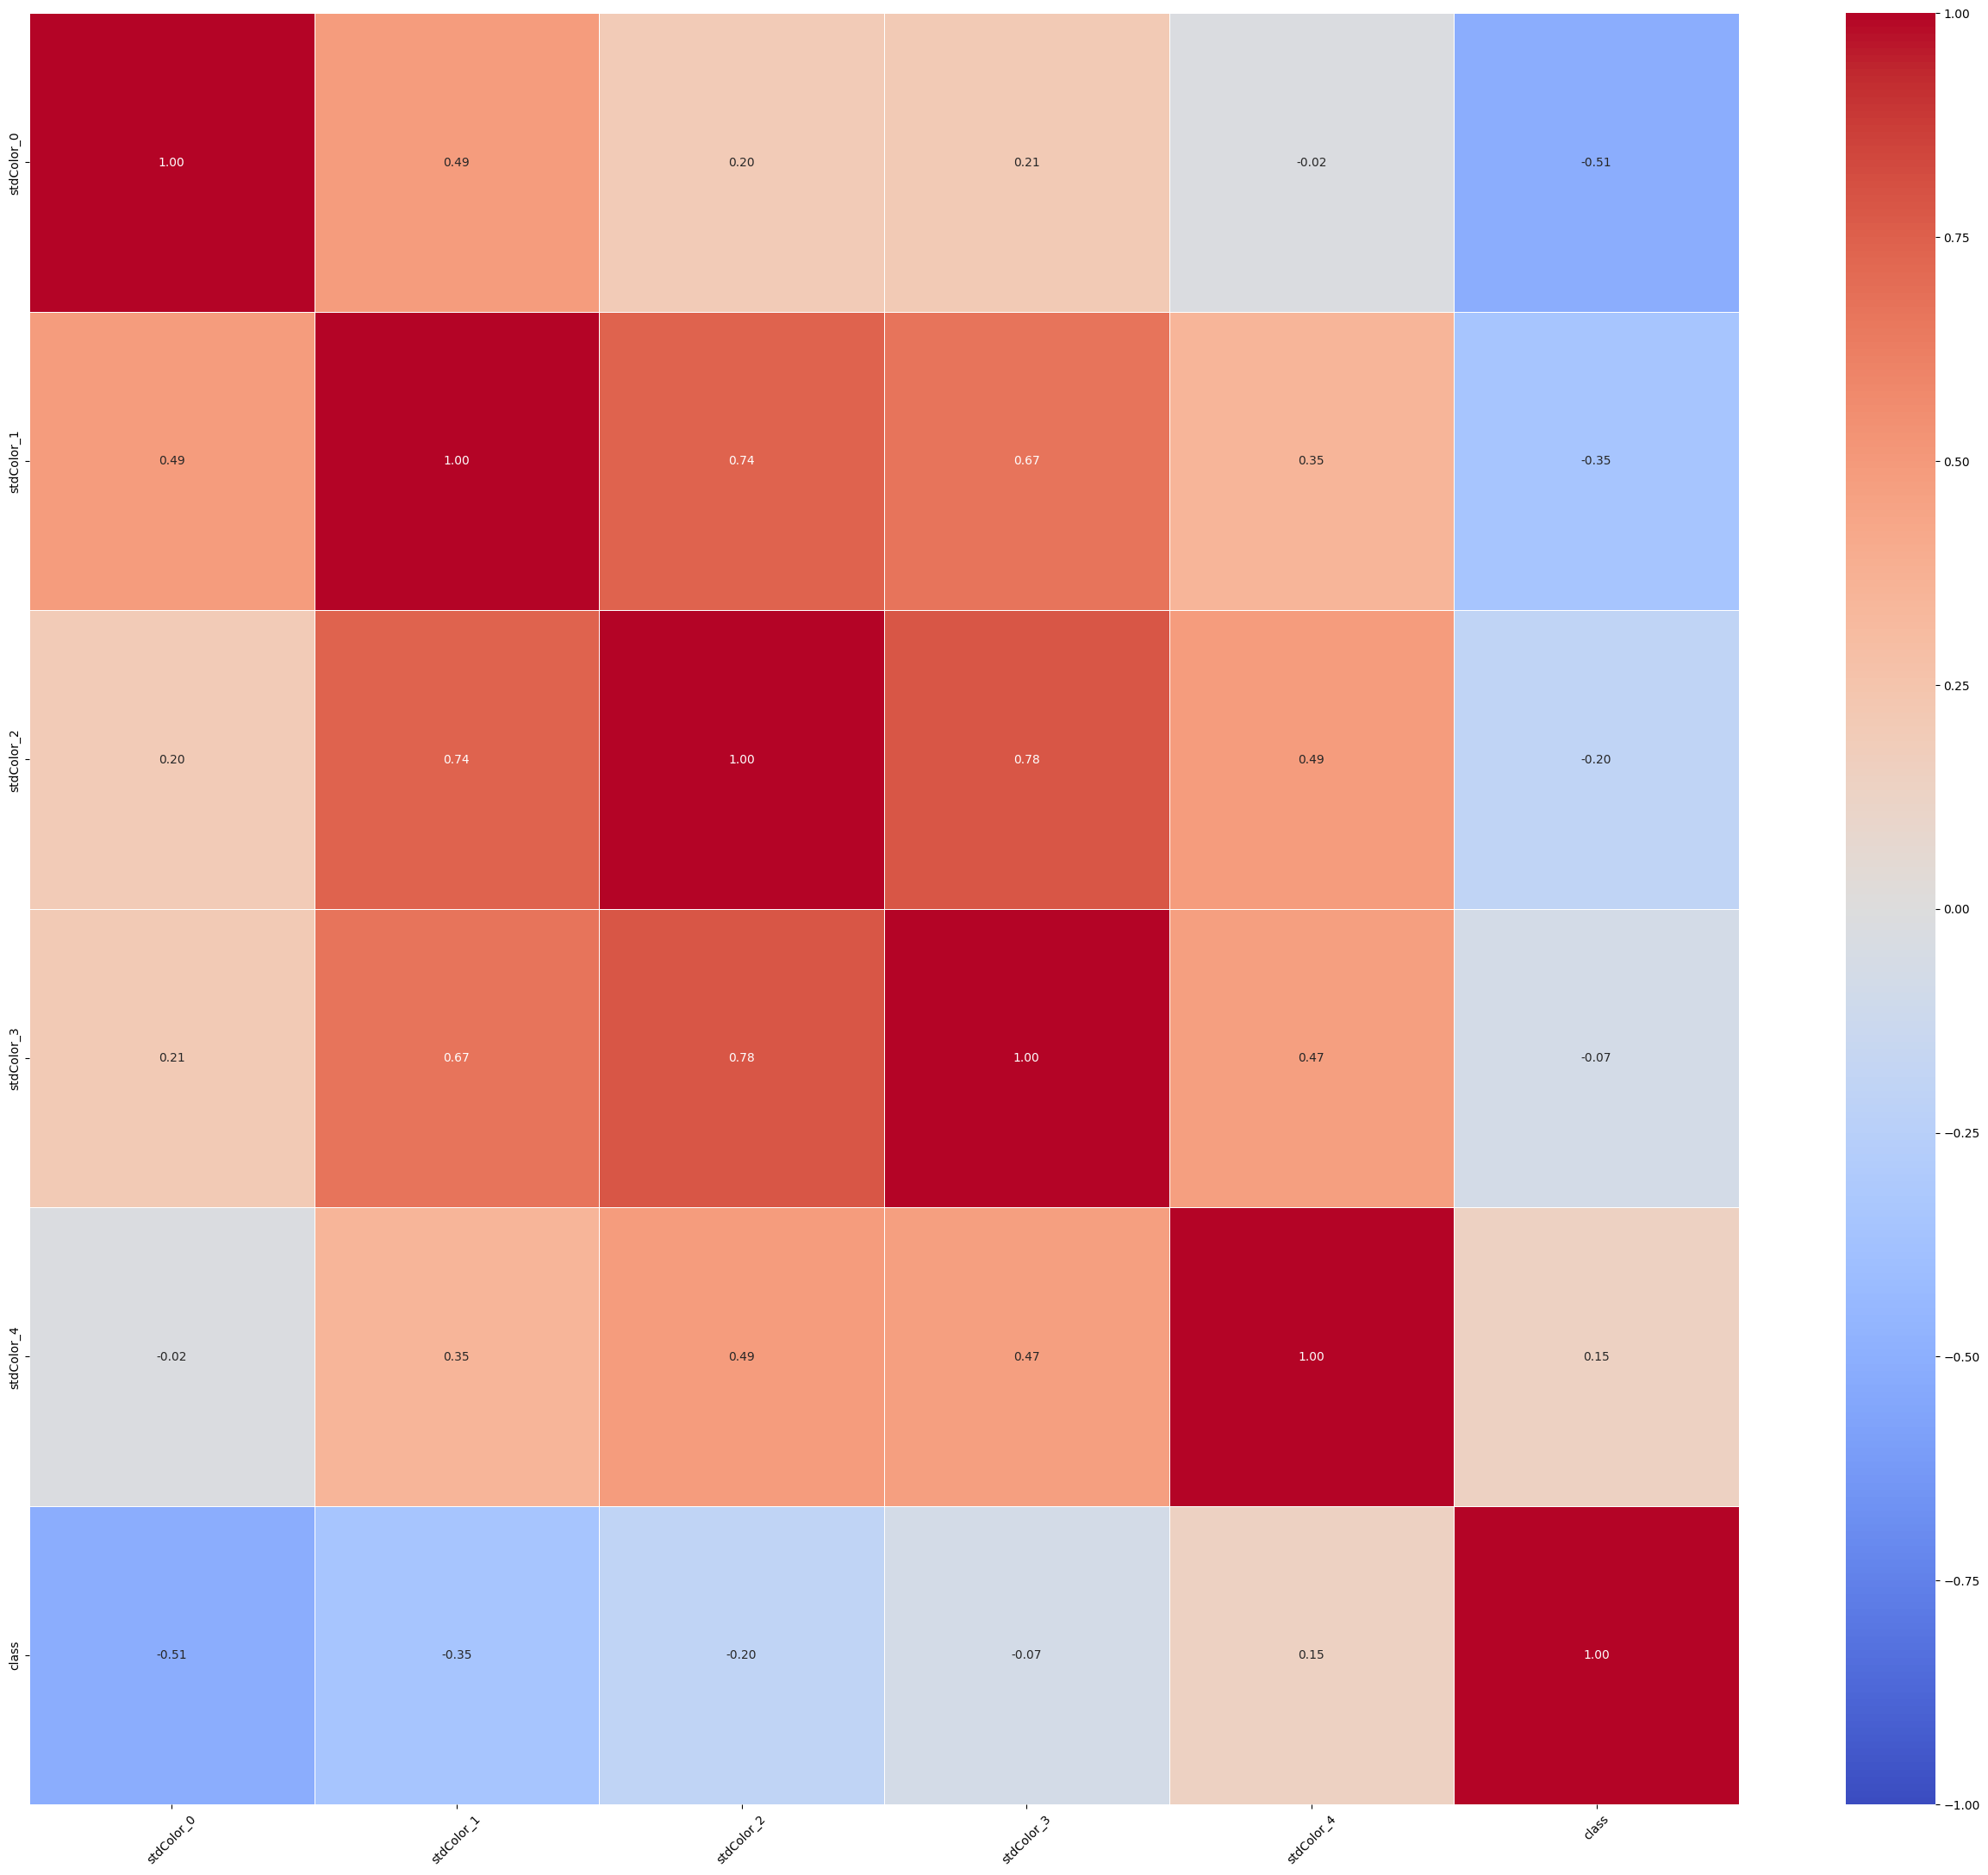

In [8]:
# Correlation matrix of the total sample of selected sources. Can be skipped when running the code.
corr = sample1_good.corr(method='spearman')
fig, ax = plt.subplots(figsize=(32,27))
sns.heatmap(data=corr, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1, linewidth=0.5)
plt.xticks(rotation=45)
plt.show()

array([[<Axes: title={'center': 'stdColor_0'}>,
        <Axes: title={'center': 'stdColor_1'}>],
       [<Axes: title={'center': 'stdColor_2'}>,
        <Axes: title={'center': 'stdColor_3'}>],
       [<Axes: title={'center': 'stdColor_4'}>, <Axes: >]], dtype=object)

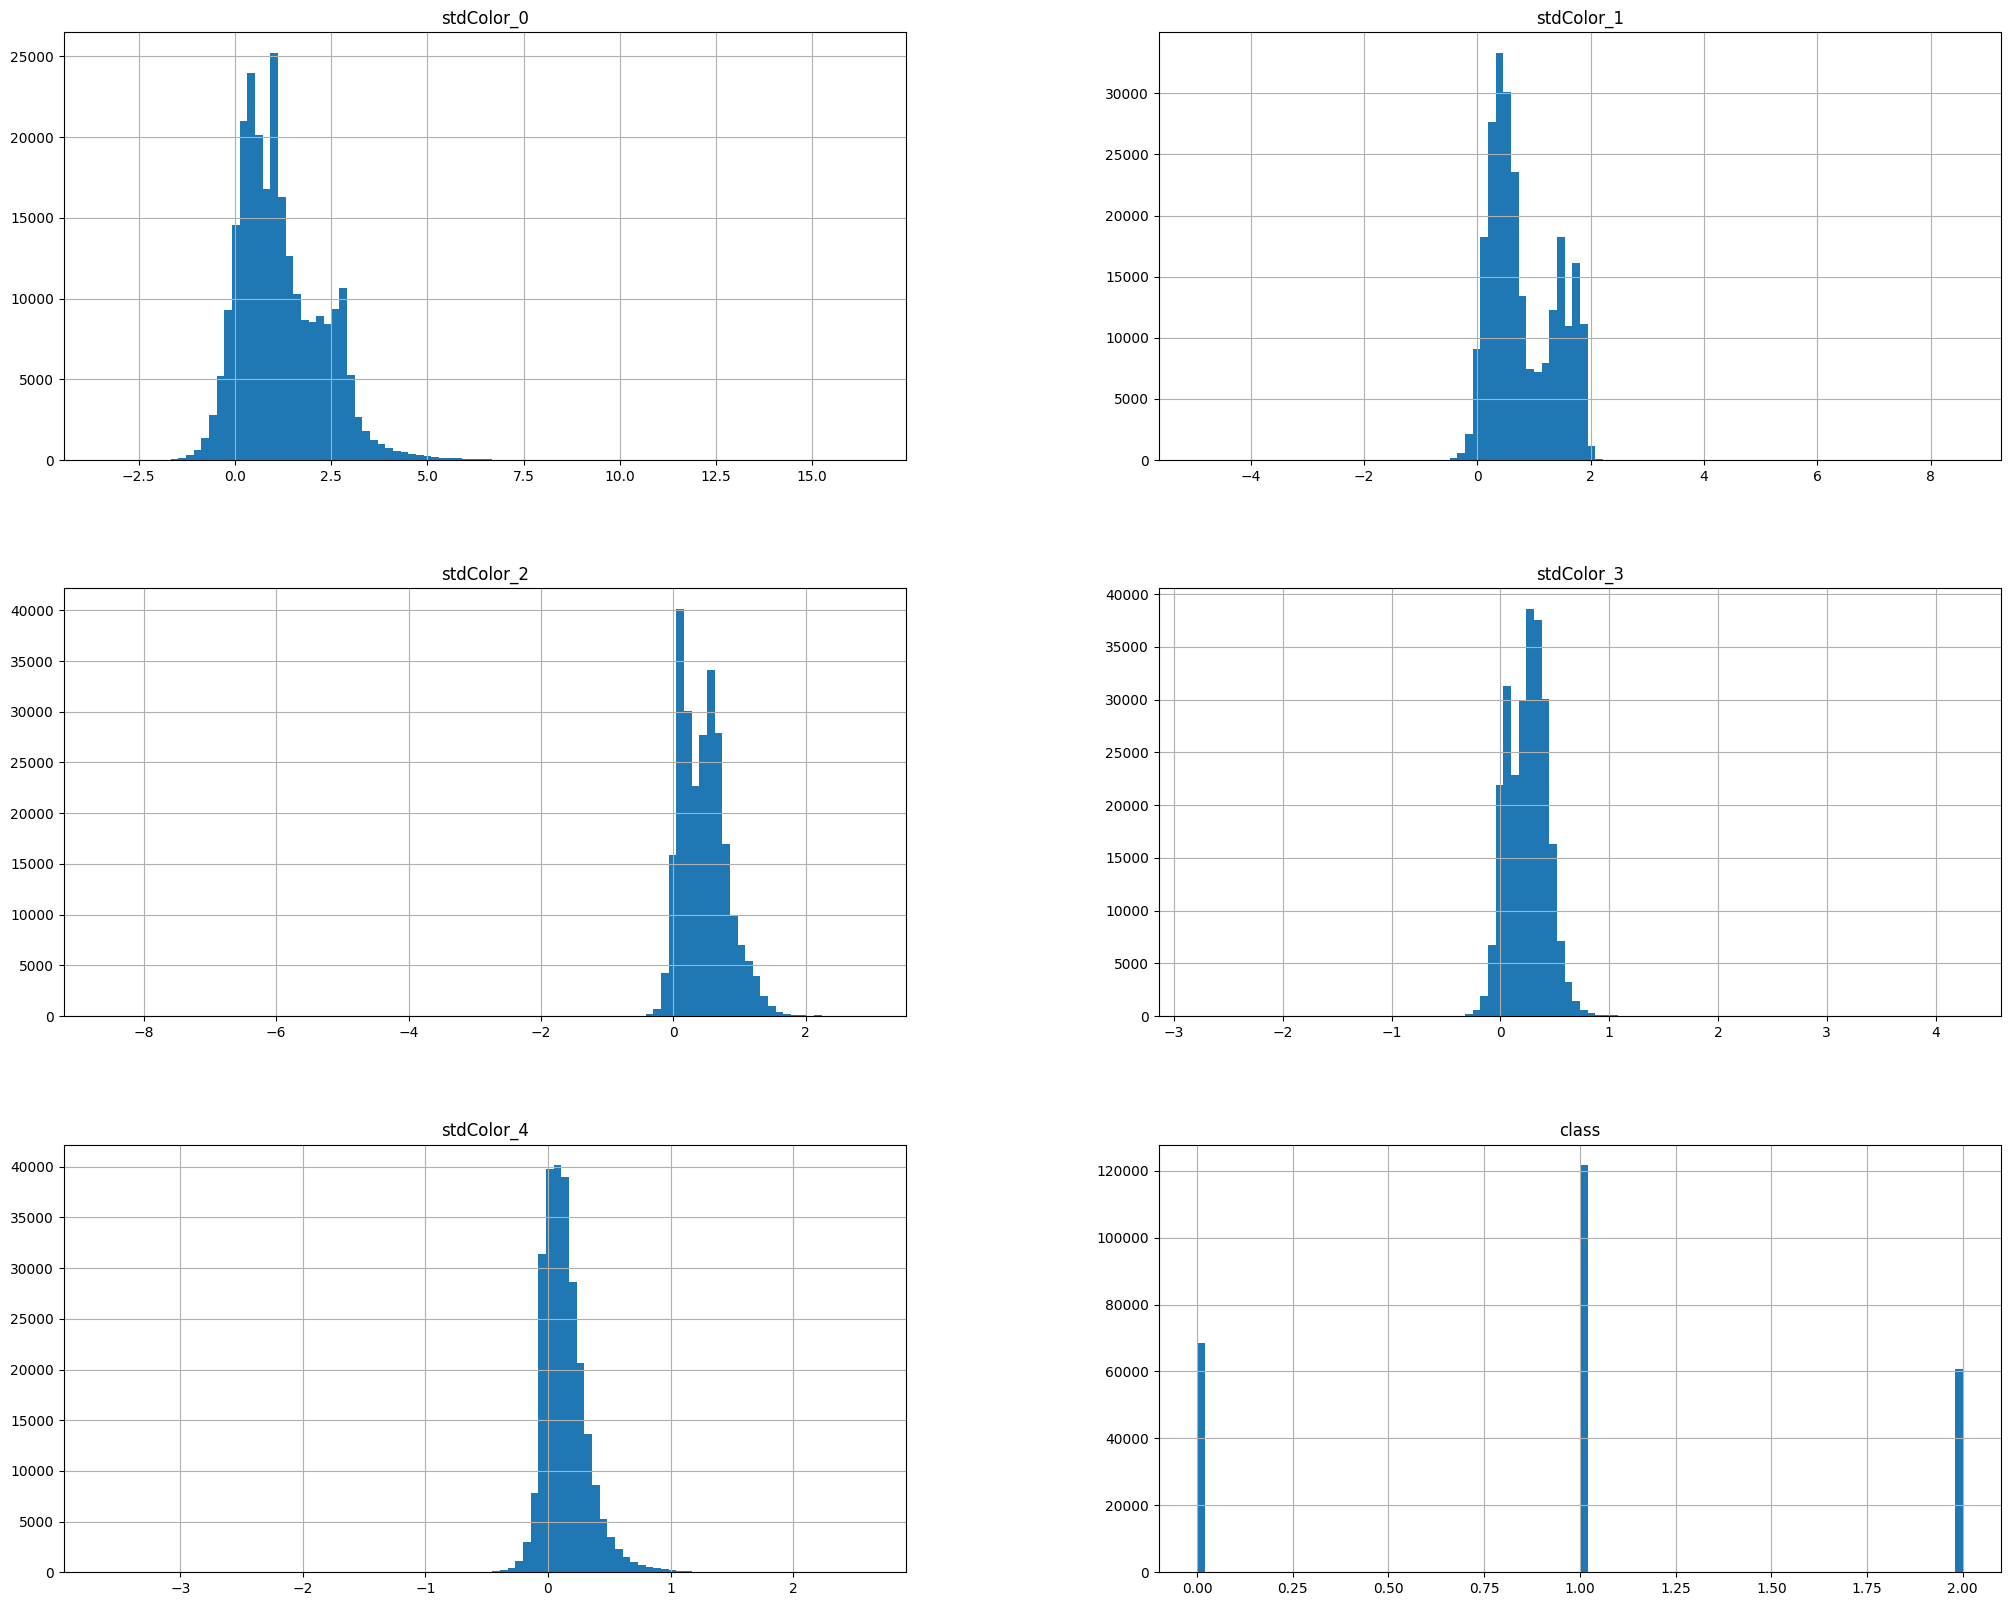

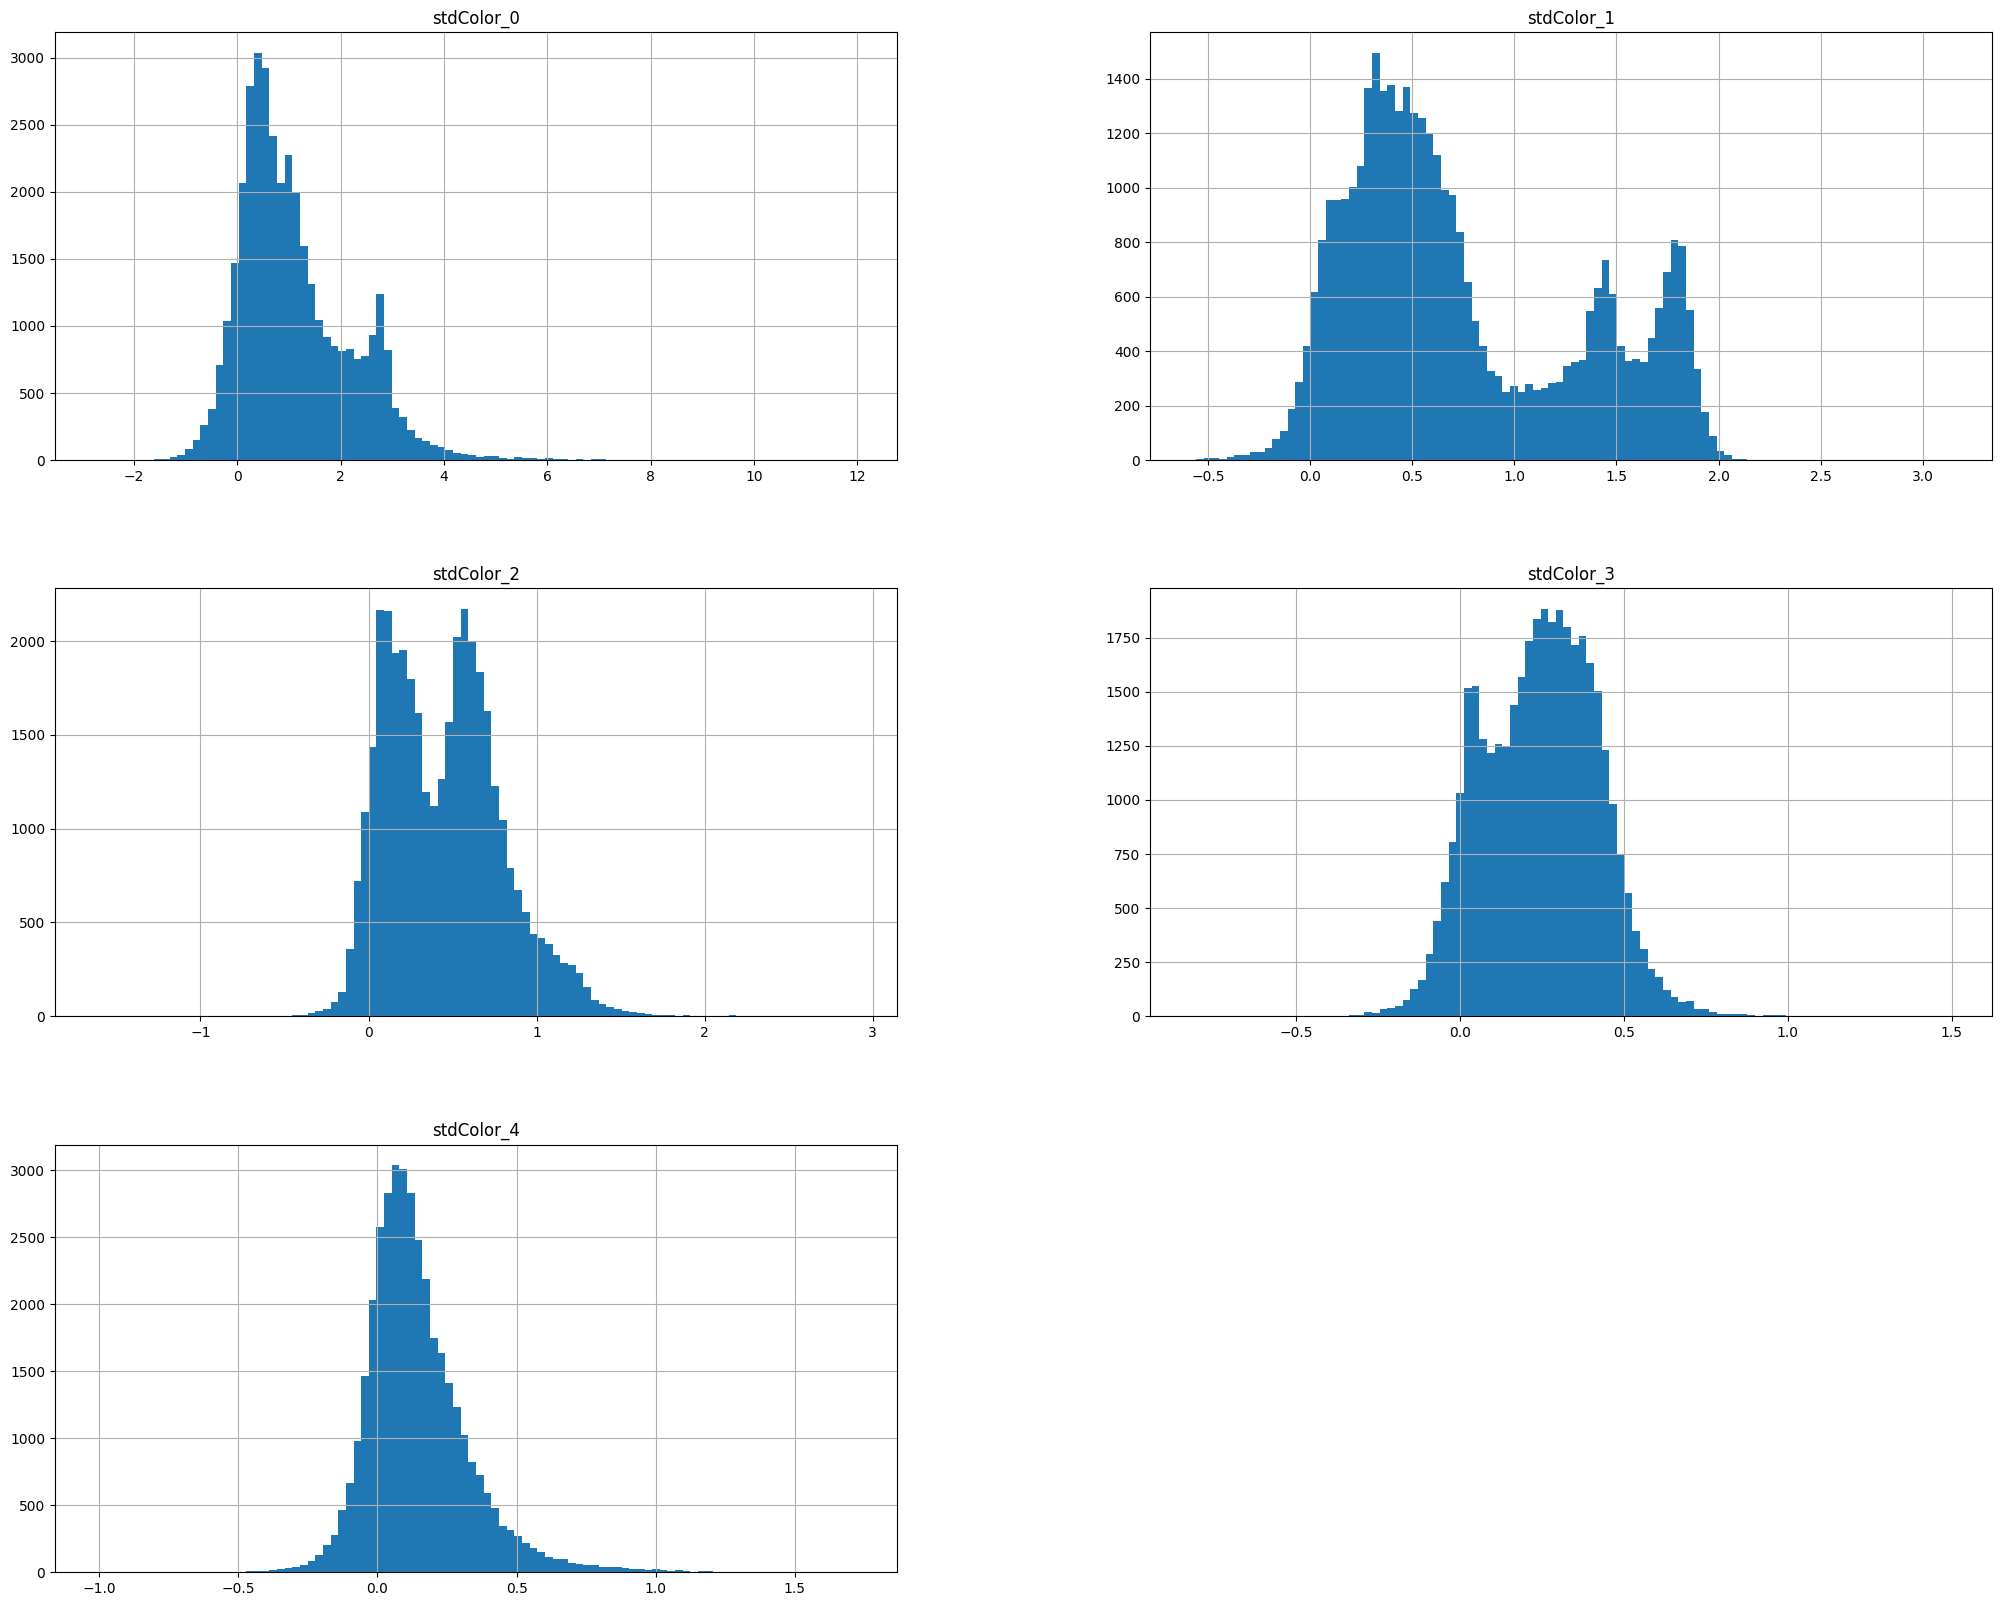

In [9]:
# Quick histograms of selected attributes for labeled and unlabeled data. Can be skipped.
sample1_good.hist(figsize = [25,20], bins=100)
sample1_good_unlab.hist(figsize = [25,20], bins=100)

### Data preprocessing 
Assigning X and y from the sample. After dropping NaN or missing values, we are left with a subsample consisting of 128072 objects, roughly 1/4 of the total number of objects in the Stripe82 Object Table (436990 objects with known labels).

In [10]:
X = sample1_good
# removing the class attribute from X data array
X = X.drop(['class'], axis=1)

# storing labels for later
y = sample1_good['class']
display(X.shape, y.shape)
display(X.describe())

(251092, 5)

(251092,)

,stdColor_0,stdColor_1,stdColor_2,stdColor_3,stdColor_4
count,251092.000000,251092.000000,251092.000000,251092.000000,251092.000000
mean,1.192455,0.796617,0.458105,0.246363,0.137506
std,1.097236,0.577364,0.350144,0.179869,0.181409
min,-3.456974,-4.951052,-8.632828,-2.787663,-3.639812
25%,0.383977,0.338318,0.165244,0.097926,0.010907
50%,0.989902,0.611921,0.444655,0.257902,0.111104
75%,1.892795,1.360131,0.669739,0.372838,0.225287
max,16.439950,8.568064,2.936810,4.250202,2.608742


In [11]:
## Splitting data to train, test followed by standardization
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = 0.5, random_state = 1)

## standardization using StandardScaler applied to X_train (yields mean and sigma for X_train)
## and then standardizing X_train and X_test and X_unlab with mean and sigma obtained from X_train
scaler = preprocessing.StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
X_unlab = scaler.transform(np.array(sample1_good_unlab))

display(X_train.shape, X_test.shape, X_unlab.shape)

/home/yan/PythonWorkdir/MASS_SummerSchool/.ai_env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


(125546, 5)

(125546, 5)

(37508, 5)

## 3. Neural network classifier
Defining the neural network preliminary architecture design, number of neurons, hidden layers etc...
The main architecture is the following: input layer and two dense layers followed by an output layer. Model description
and graph is alsho showed. The highest accuracy reached for this model with k-fold cross validation was 98.5 +- 0.1. 
Overall worse performance by up to 0.2% than the random forest classifer. It is important to note that this is the simplest
neural network architecture used here. However, the possibility of image inclusion and training a joint model allows 
for further improvement that has been investigated in a separate notebook.

5

42

35

2025-07-16 12:22:22.200490: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 5)              │            30 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 42)             │           252 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 35)             │         1,505 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,787 (6.98 KB)

 Trainable params: 1,787 (6.98 KB)

 Non-trainable params: 0 (0.00 B)

None

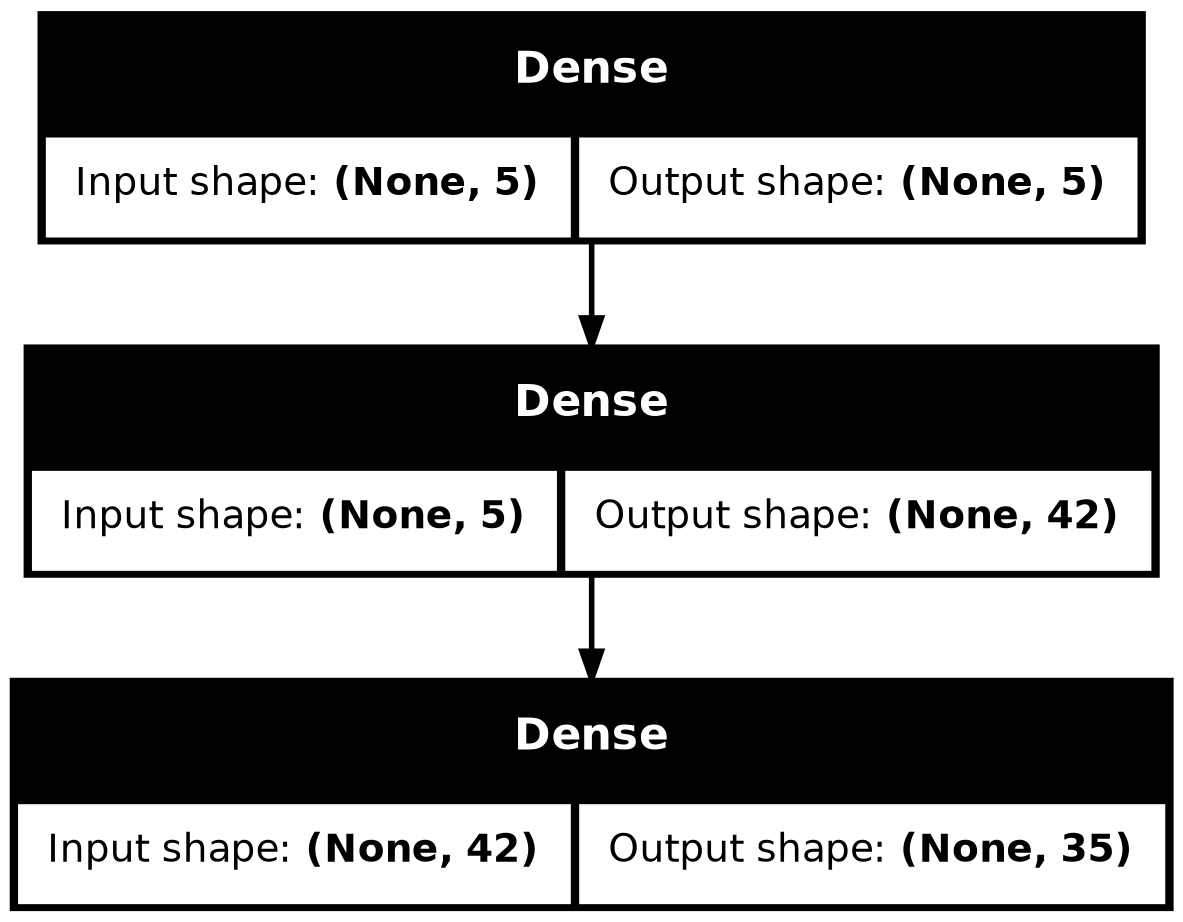

Epoch 1/20


/home/yan/PythonWorkdir/MASS_SummerSchool/.ai_env/lib/python3.12/site-packages/keras/src/backend/tensorflow/nn.py:717: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


3924/3924 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.7871 - loss: 0.8028
Epoch 2/20
3924/3924 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9102 - loss: 0.2995
Epoch 3/20
3924/3924 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.9201 - loss: 0.2700
Epoch 4/20
3924/3924 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.9247 - loss: 0.2462
Epoch 5/20
3924/3924 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9292 - loss: 0.2313
Epoch 6/20
3924/3924 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9299 - loss: 0.2272
Epoch 7/20
3924/3924 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9330 - loss: 0.2137
Epoch 8/20
3924/3924 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9350 - loss: 0.2051
Epoch 9/20
3924/3924 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9342 - loss: 0.2043
Epoch 10/20
3924/3924 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.9357 - loss: 0.1998
Epoch 11/20
3924/3924 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.9363 - loss: 0.2008
Epoch 12/20
3924/3924 ━━━━━━━━━━━━━━

In [12]:
n_input_layer = X_train.shape[1]
n_output_layer = 35
n_middle_layer = 42
num_epochs = 20
display(n_input_layer, n_middle_layer, n_output_layer,)


model = tf.keras.Sequential([
    # ① Either an explicit Input layer…
    tf.keras.Input(shape=(n_input_layer,)),          # KerasTensor, not counted in model.summary()

    # ② …or supply input_shape= on your first Dense and omit the line above:
    # tf.keras.layers.Dense(units=n_input_layer, activation='elu', input_shape=(n_input_layer,)),

    tf.keras.layers.Dense(units=n_input_layer,  activation='elu'),
    tf.keras.layers.Dense(units=n_middle_layer, activation='elu'),
    tf.keras.layers.Dense(units=n_output_layer, activation='sigmoid')  # use 'softmax' for multi‑class
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'],
              )

display(model.summary())
display(tf.keras.utils.plot_model(model, to_file='NN.png', show_shapes=True))

history = model.fit(X_train, y_train, epochs=num_epochs)

Plotting results. True labels are on the vertical axis while the predicted labels are on the horizontal axis

3924/3924 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step  
1173/1173 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


'accuracy score of:  0.9402529750051773'

'total number of class, number of missclasified objects (array([34327, 60798, 30421]), array([1206, 2644, 3651]))'

'f1 score is:  [0.95765566 0.9512235  0.8975842 ]'

0
1    17750
2    10927
0     8831
Name: count, dtype: int64

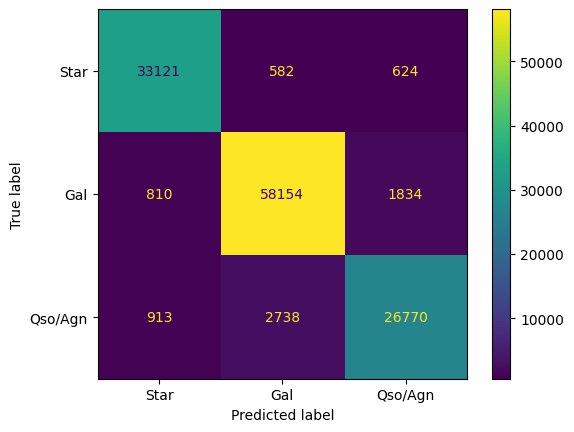

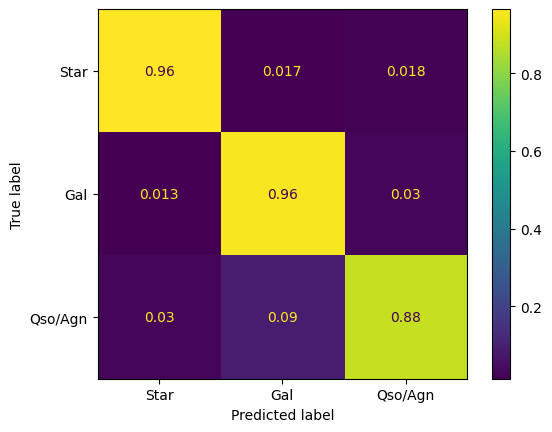

In [13]:
y_pred_NN = np.argmax(model.predict(X_test), axis=1)
y_unlab_NN = pd.DataFrame(np.argmax(model.predict(X_unlab), axis=1))

cf = confusion_matrix(y_test, y_pred_NN)
labels_misscla = np.array(np.sum(cf, axis=1) - np.diag(cf))

cf_n = np.zeros(cf.shape)
for i in range(cf.shape[0]):
    row_normalized = np.divide(cf[i, :], np.sum(cf[i, :]))
    cf_n[i, :] = row_normalized

str_labels = ['Star', 'Gal', 'Qso/Agn']
ConfusionMatrixDisplay(cf, display_labels=str_labels).plot()
ConfusionMatrixDisplay(cf_n, display_labels=str_labels).plot()
display(f"accuracy score of:  {accuracy_score(y_test, y_pred_NN)}")
display(f"total number of class, number of missclasified objects {np.sum(cf, axis=1),labels_misscla.T}")
display(f"f1 score is:  {f1_score(y_test, y_pred_NN, average=None)}")
display(pd.DataFrame(y_unlab_NN).value_counts())

## 4. Support vector machine classifier
Create a SVM classifier takes around 10 mins to be trained on SciServer for user djsavic. Training with linear kernel is considerably longer and the performance is worse by 0.5% when compared to rbf. Rbf kernel performs the best. SVM Penalty factor of the order ~1-10 works the best.

In [14]:
rbf = svm.SVC(kernel='rbf', C=10, decision_function_shape='ovo')

#Train the model using the training sets y_pred=rbf.predict(X_test)
rbf.fit(X_train, y_train)
y_pred_SVM = rbf.predict(X_test)
y_unlab_SVM = rbf.predict(X_unlab)
display(pd.DataFrame(y_unlab_SVM).value_counts())

0  
1.0    17951
2.0    10794
0.0     8763
Name: count, dtype: int64

'Classifier performance'

'accuracy score of:  0.9490465646058018'

'total number of class, number of missclasified objects (array([34327, 60798, 30421]), array([ 964, 2053, 3380]))'

'f1 score is:  [0.96953053 0.95669663 0.90953734]'

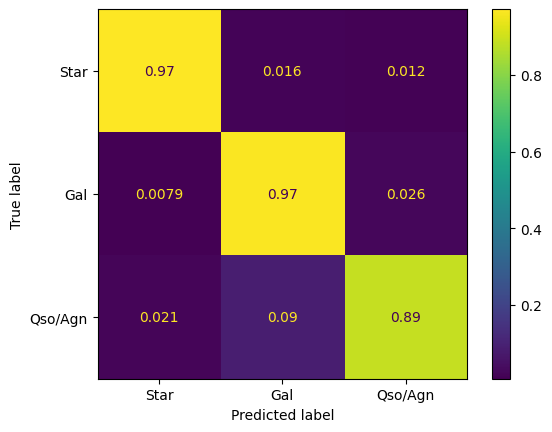

In [15]:
cf = confusion_matrix(y_test, y_pred_SVM)
cf_n = np.zeros(cf.shape)
labels_misscla_SVM = np.array(np.sum(cf, axis=1) - np.diag(cf))
for i in range(cf.shape[0]):
    row_normalized = np.divide(cf[i, :], np.sum(cf[i, :]))
    cf_n[i, :] = row_normalized

ConfusionMatrixDisplay(cf_n, display_labels=str_labels).plot()
display("Classifier performance")
display(f"accuracy score of:  {accuracy_score(y_test, y_pred_SVM)}")
display(f"total number of class, number of missclasified objects {np.sum(cf, axis=1),labels_misscla_SVM.T}")
display(f"f1 score is:  {f1_score(y_test, y_pred_SVM, average=None)}")

## 5. Random forest classificator
Create a random forest classifier. Around 98.4% accuracy overall.

In [16]:
clf=RandomForestClassifier(n_estimators=2001, n_jobs=70, criterion="entropy")

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train, y_train)
y_pred_rf=clf.predict(X_test)
y_unlab_rf = clf.predict(X_unlab)
display(pd.DataFrame(y_unlab_rf).value_counts())
display(f"acc: {accuracy_score(y_test, y_pred_rf)}")

0  
1.0    18081
2.0    10938
0.0     8489
Name: count, dtype: int64

'acc: 0.9529495165118761'

'accuracy score of:  0.9529495165118761'

'total number of class, number of missclasified objects (array([34327, 60798, 30421]), array([ 945, 1891, 3071]))'

'f1 score is:  [0.97494159 0.95864796 0.91600241]'

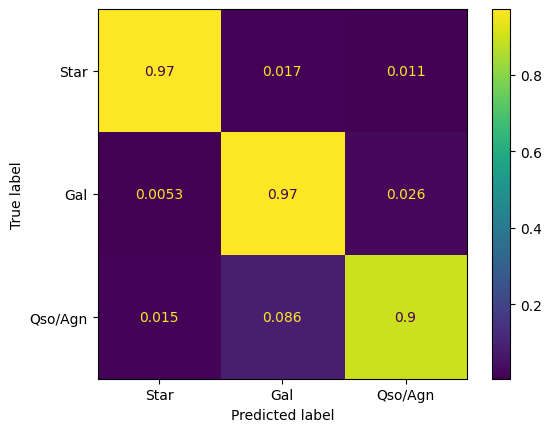

In [17]:
cf = confusion_matrix(y_test, y_pred_rf)
cf_n = np.zeros(cf.shape)
labels_misscla_rf = np.array(np.sum(cf, axis=1) - np.diag(cf))
for i in range(cf.shape[0]):
    row_normalized = np.divide(cf[i, :], np.sum(cf[i, :]))
    cf_n[i, :] = row_normalized

ConfusionMatrixDisplay(cf_n, display_labels=str_labels).plot()
display(f"accuracy score of:  {accuracy_score(y_test, y_pred_rf)}")
display(f"total number of class, number of missclasified objects {np.sum(cf, axis=1),labels_misscla_rf.T}")
display(f"f1 score is:  {f1_score(y_test, y_pred_rf, average=None)}")

## 6. Gaussian Naive Bayers

In [18]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)
gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)
print("Number of mislabeled points out of a total %d points : %d"
      % (X_test.shape[0], (y_test != y_pred).sum()))
print(X_test.shape)

Number of mislabeled points out of a total 125546 points : 30620
(125546, 5)


'accuracy score of:  0.7561053319102162'

'total number of class, number of missclasified objects (array([34067, 61025, 30454]), array([21555,  5728,  3337]))'

'f1 score is:  [0.49567198 0.88300718 0.71966561]'

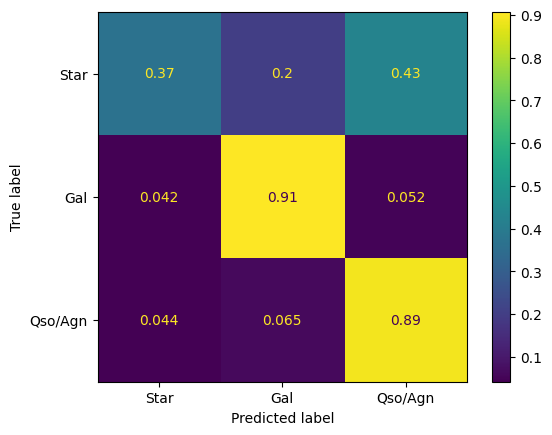

In [19]:
cf = confusion_matrix(y_test, y_pred)
cf_n = np.zeros(cf.shape)
labels_misscla_rf = np.array(np.sum(cf, axis=1) - np.diag(cf))
for i in range(cf.shape[0]):
    row_normalized = np.divide(cf[i, :], np.sum(cf[i, :]))
    cf_n[i, :] = row_normalized

ConfusionMatrixDisplay(cf_n, display_labels=str_labels).plot()
display(f"accuracy score of:  {accuracy_score(y_test, y_pred)}")
display(f"total number of class, number of missclasified objects {np.sum(cf, axis=1),labels_misscla_rf.T}")
display(f"f1 score is:  {f1_score(y_test, y_pred, average=None)}")

## 7. Conclusion

This notebook demonstrates the usage of three supervised machine learning classifiers: neural networks, support vector machine and random forest. Accuracy score for each classificator in this example is:

 NN - 98.343%  
SVM - 98.294%  
 RF - 98.422%  

We were able to achieve a high baseline accuracy for each method (acc>98%) when the adequate periodicity (and nonperiodicity) parameters are selected. The random forest performs the best overall on this subset of data, which is very often the case for machine learning applications on tabular data. 
Using the same models on tabular data without periodicity parameters (e.g., psMag, bdMag, psFlux, bdFlux, stdcolor, extendedness) reduces the classification to 93-95% accuracy.

When training neural network in this example, the performance depends on the initial conditions when neural network model is instantiated and compiled, which results in varying accuracy around 98.3% +- 0.2%, which makes them unstable per initial conditions.  
This test is a first step towards more advanced machine learning models and serves as a comparison with other models. The performance of neural networks with images included is described in a separate notebook.

---
### => WY: Test on Blinded Dataset <=

#### 1. Read the blindeded dataset & Preprocess
- Read the full blinded dataset & clean up
- Re-format and get ready for test

In [26]:
# read whole dataset
blinded_df_og = pd.read_parquet('Datasets/ObjectTable_Blinded.parquet')

# select those having LCs & and computed features
lc_cols = [col for col in blinded_df_og.columns if 'Periodic' in col]
blinded_df = blinded_df_og.dropna(subset=lc_cols, how='all').copy()

# select only the columns specified above (see attr_list) & drop nan
blinded_df = blinded_df[attr_list].dropna()

# replace class str with int
blinded_df = blinded_df.replace({'class': {'Star': 0, 'Gal': 1, 'Qso': 2, 'Agn': 2, 'highZQso': 2}})

# print number of objects in the final blinded test set
print(f'Total Number of objects in the final blinded test set: {len(blinded_df)}')
print('Counts for each class: ')
blinded_df['class'].value_counts()

Total Number of objects in the final blinded test set: 15287
Counts for each class: 


/tmp/ipykernel_71448/4079935408.py:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  blinded_df = blinded_df.replace({'class': {'Star': 0, 'Gal': 1, 'Qso': 2, 'Agn': 2, 'highZQso': 2}})


class
1    8780
2    5231
0    1276
Name: count, dtype: int64

In [27]:
# re-format
X_b = blinded_df.drop(['class'], axis=1)
y_b = blinded_df['class']

# re-scale
# scaler = preprocessing.StandardScaler()
# scaler.fit(X_b)
X_b = scaler.transform(X_b)

print(X_b)

[[ 6.46935193e-01 -5.29602877e-02 -5.68697210e-01 -7.14448908e-01
  -3.18664892e-04]
 [-7.45894749e-02 -1.31314414e+00 -1.48458942e+00 -1.61869517e+00
  -1.18607149e+00]
 [ 8.52611691e-02 -2.68648000e-01 -6.37512510e-01 -7.11148800e-01
  -4.51597941e-01]
 ...
 [-2.30114738e-01 -6.38573824e-01 -2.14407679e-01 -1.07593811e+00
  -9.32294151e-01]
 [-1.63295894e-01 -6.30119791e-01 -1.25279067e+00 -2.35224467e-01
  -5.52871695e-01]
 [-5.89958094e-01 -1.10395048e+00 -1.03554977e+00 -1.19272175e-01
   5.75983272e-02]]


#### 2. Test the NN classifier

478/478 ━━━━━━━━━━━━━━━━━━━━ 0s 685us/step


'accuracy score of:  0.9095963890887683'

'total number of class, number of missclasified objects (array([1276, 8780, 5231]), array([139, 510, 733]))'

'f1 score is:  [0.83818651 0.93520299 0.88412776]'

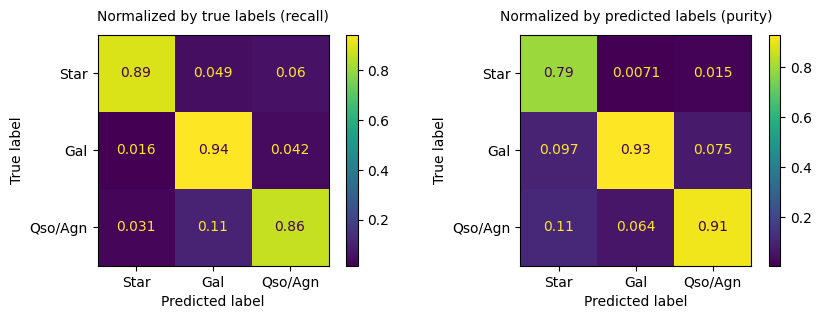

In [28]:
# predict
y_b_pred_NN = np.argmax(model.predict(X_b), axis=1)

# make cf matrix & compute statistics
cf = confusion_matrix(y_b, y_b_pred_NN)
labels_misscla = np.array(np.sum(cf, axis=1) - np.diag(cf))

cf_n = np.zeros(cf.shape)
for i in range(cf.shape[0]):
    row_normalized = np.divide(cf[i, :], np.sum(cf[i, :]))
    cf_n[i, :] = row_normalized

# make plots    
fig, axes = plt.subplots(1, 2, dpi=100, figsize=(10, 3))
cf_n_t = confusion_matrix(y_b, y_b_pred_NN, normalize='true')
cf_n_p = confusion_matrix(y_b, y_b_pred_NN, normalize='pred')
ConfusionMatrixDisplay(cf_n_t, display_labels=str_labels).plot(ax=axes[0])
ConfusionMatrixDisplay(cf_n_p, display_labels=str_labels).plot(ax=axes[1])
axes[0].set_title('Normalized by true labels (recall)', pad=10, fontsize=10)
axes[1].set_title('Normalized by predicted labels (purity)', pad=10, fontsize=10)

display(f"accuracy score of:  {accuracy_score(y_b, y_b_pred_NN)}")
display(f"total number of class, number of missclasified objects {np.sum(cf, axis=1),labels_misscla.T}")
display(f"f1 score is:  {f1_score(y_b, y_b_pred_NN, average=None)}")

#### 3. Test the SVM classifier

'accuracy score of:  0.9230064760907961'

'total number of class, number of missclasified objects (array([1276, 8780, 5231]), array([ 95, 387, 695]))'

'f1 score is:  [0.88431299 0.94271594 0.8984847 ]'

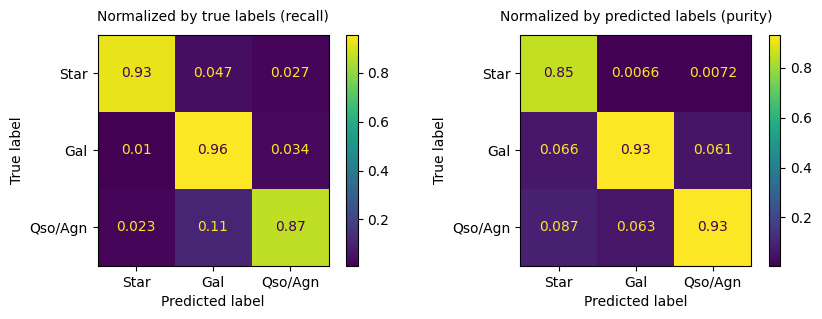

In [29]:
# predict
y_b_pred_SVM = rbf.predict(X_b)

# make cf matrix & compute statistics
cf = confusion_matrix(y_b, y_b_pred_SVM)
labels_misscla = np.array(np.sum(cf, axis=1) - np.diag(cf))

cf_n = np.zeros(cf.shape)
for i in range(cf.shape[0]):
    row_normalized = np.divide(cf[i, :], np.sum(cf[i, :]))
    cf_n[i, :] = row_normalized
    
# make plots    
fig, axes = plt.subplots(1, 2, dpi=100, figsize=(10, 3))
cf_n_t = confusion_matrix(y_b, y_b_pred_SVM, normalize='true')
cf_n_p = confusion_matrix(y_b, y_b_pred_SVM, normalize='pred')
ConfusionMatrixDisplay(cf_n_t, display_labels=str_labels).plot(ax=axes[0])
ConfusionMatrixDisplay(cf_n_p, display_labels=str_labels).plot(ax=axes[1])    
axes[0].set_title('Normalized by true labels (recall)', pad=10, fontsize=10)
axes[1].set_title('Normalized by predicted labels (purity)', pad=10, fontsize=10)

display(f"accuracy score of:  {accuracy_score(y_b, y_b_pred_SVM)}")
display(f"total number of class, number of missclasified objects {np.sum(cf, axis=1),labels_misscla.T}")
display(f"f1 score is:  {f1_score(y_b, y_b_pred_SVM, average=None)}")

#### 4. Test the random forest classifier

'accuracy score of:  0.9302021325309087'

'total number of class, number of missclasified objects (array([1276, 8780, 5231]), array([ 98, 331, 638]))'

'f1 score is:  [0.90930143 0.94613662 0.90743851]'

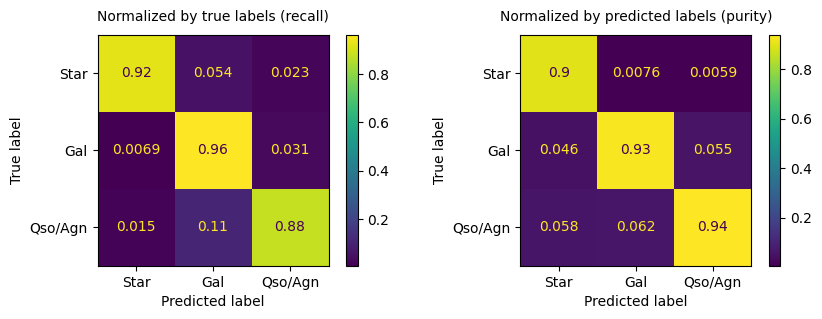

In [30]:
# predict
y_b_pred_rf = clf.predict(X_b)

# make cf matrix & compute statistics
cf = confusion_matrix(y_b, y_b_pred_rf)
labels_misscla = np.array(np.sum(cf, axis=1) - np.diag(cf))

cf_n = np.zeros(cf.shape)
for i in range(cf.shape[0]):
    row_normalized = np.divide(cf[i, :], np.sum(cf[i, :]))
    cf_n[i, :] = row_normalized

# make plots    
fig, axes = plt.subplots(1, 2, dpi=100, figsize=(10, 3))
cf_n_t = confusion_matrix(y_b, y_b_pred_rf, normalize='true')
cf_n_p = confusion_matrix(y_b, y_b_pred_rf, normalize='pred')
ConfusionMatrixDisplay(cf_n_t, display_labels=str_labels).plot(ax=axes[0])
ConfusionMatrixDisplay(cf_n_p, display_labels=str_labels).plot(ax=axes[1])    
axes[0].set_title('Normalized by true labels (recall)', pad=10, fontsize=10)
axes[1].set_title('Normalized by predicted labels (purity)', pad=10, fontsize=10)

display(f"accuracy score of:  {accuracy_score(y_b, y_b_pred_rf)}")
display(f"total number of class, number of missclasified objects {np.sum(cf, axis=1),labels_misscla.T}")
display(f"f1 score is:  {f1_score(y_b, y_b_pred_rf, average=None)}")

#### 4. Gaussian Naive Bayers

/home/yan/PythonWorkdir/MASS_SummerSchool/.ai_env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(


'accuracy score of:  0.4987244063583437'

'total number of class, number of missclasified objects (array([1276, 8780, 5231]), array([ 822, 3774, 3067]))'

'f1 score is:  [0.15725667 0.69224919 0.41869014]'

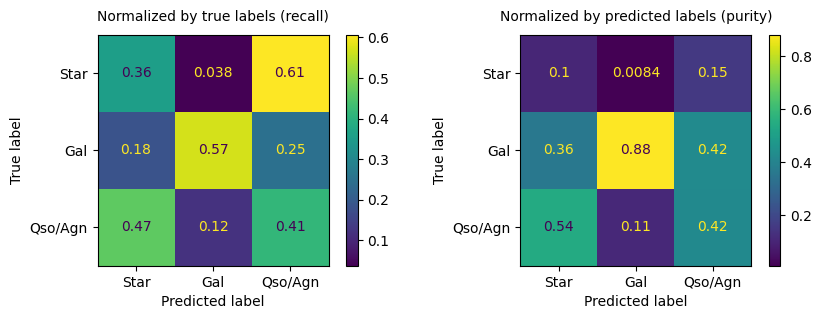

In [31]:
# predict
y_b_pred_gnb = gnb.predict(X_b)

# make cf matrix & compute statistics
cf = confusion_matrix(y_b, y_b_pred_gnb)
labels_misscla = np.array(np.sum(cf, axis=1) - np.diag(cf))

cf_n = np.zeros(cf.shape)
for i in range(cf.shape[0]):
    row_normalized = np.divide(cf[i, :], np.sum(cf[i, :]))
    cf_n[i, :] = row_normalized

# make plots    
fig, axes = plt.subplots(1, 2, dpi=100, figsize=(10, 3))
cf_n_t = confusion_matrix(y_b, y_b_pred_gnb, normalize='true')
cf_n_p = confusion_matrix(y_b, y_b_pred_gnb, normalize='pred')
ConfusionMatrixDisplay(cf_n_t, display_labels=str_labels).plot(ax=axes[0])
ConfusionMatrixDisplay(cf_n_p, display_labels=str_labels).plot(ax=axes[1])    
axes[0].set_title('Normalized by true labels (recall)', pad=10, fontsize=10)
axes[1].set_title('Normalized by predicted labels (purity)', pad=10, fontsize=10)

display(f"accuracy score of:  {accuracy_score(y_b, y_b_pred_gnb)}")
display(f"total number of class, number of missclasified objects {np.sum(cf, axis=1),labels_misscla.T}")
display(f"f1 score is:  {f1_score(y_b, y_b_pred_gnb, average=None)}")